In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [894]:
data_0 = pandas.read_csv('Data/hits.csv', index_col=0)

data_1 = data_0.copy()
data_1['Wy1'] = data_0['Wy1'].values + data_0.dist2Wire.values
data_1['Wy2'] = data_0['Wy2'].values + data_0.dist2Wire.values
data_2 = data_0.copy()
data_2['Wy1'] = data_0['Wy1'].values - data_0.dist2Wire.values
data_2['Wy2'] = data_0['Wy2'].values - data_0.dist2Wire.values
data = pandas.concat([data_1, data_2], axis=0)

#data = pandas.read_csv('Data/hits.csv', index_col=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,0.042245,-250.000000,250.000000,0.910845,0.910845,2581.1500,2581.1500,2581.1500,0,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,0.478996,-248.589486,249.507863,27.516483,-16.061389,3542.3793,3542.3793,3542.3793,0,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,0.310706,-248.587499,249.509850,-26.749494,16.828378,2592.3793,2592.3793,2592.3793,0,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,0.117904,-248.894287,249.203062,-23.435691,20.142180,2592.3793,2592.3793,2592.3793,1,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,0.437575,-250.000000,250.000000,0.426175,0.426175,2782.2500,2782.2500,2782.2500,0,0


# Tracks Reconstruction

In [895]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator
from retina import Retina2DTrackerTwo


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [933]:
from copy import deepcopy
from scipy.optimize import minimize

class DeformableTemplates(object):
    
    def __init__(self, n_tracks, n_iters=10, lambda_=0., T=1., min_state_value=0.95):
        
        self.n_tracks = n_tracks
        self.n_iters = n_iters
        self.lambda_ = lambda_
        self.T = T
        self.min_state_value = min_state_value
        
        
        self.tracks_params_ = None
        
    def energy(self, params, x, y):
        
        params = numpy.array(params)
        
        beta = 1. / self.T
        
        dists = (y - x * params[:, 0].reshape(-1, 1) - params[:, 1].reshape(-1, 1)).T
        
        E = - 1./beta * (numpy.log(numpy.exp(-beta * self.lambda_) + numpy.exp(-beta * dists**2).sum(axis=1))).sum()
        
        return E
    
    def energy_opti(self, params, x, y):
        
        return self.energy(params.reshape(-1, 2), x, y)
    
    def energy_grad(self, params, x, y):
        
        params = numpy.array(params)
        
        beta = 1. / self.T
        
        dists = (y - x * params[:, 0].reshape(-1, 1) - params[:, 1].reshape(-1, 1)).T
        
        V_down = numpy.exp(-beta * self.lambda_) + numpy.exp(-beta * dists**2).sum(axis=1)
        
        V = numpy.exp(-beta * dists**2) / V_down.reshape(-1, 1)
        
        grad_0 = (-2. * dists * params[:, 0] * V).sum(axis=0)
        grad_1 = (-2. * dists * V).sum(axis=0)
        
        grad = numpy.concatenate((grad_0.reshape(-1, 1), grad_1.reshape(-1, 1)), axis=1)
        
        return grad
    
    def energy_grad_opti(self, params, x, y):
        
        return self.energy_grad(params.reshape(-1, 2), x, y).reshape(-1)
    
    
    def states(self, params, x, y):
        
        params = numpy.array(params)
        
        beta = 1. / self.T
        
        dists = (y - x * params[:, 0].reshape(-1, 1) - params[:, 1].reshape(-1, 1)).T
        
        V_down = numpy.exp(-beta * self.lambda_) + numpy.exp(-beta * dists**2).sum(axis=1)
        
        V = numpy.exp(-beta * dists**2) / V_down.reshape(-1, 1)
        
        return V
    
    
    def fit_one_iter(self, params, x, y):
        
        min_energy = self.energy(params, x, y)
        min_params = params
        
        for track_id in range(len(params)):
            
            params = deepcopy(min_params)
            
            for first in range(len(x)):
                for second in range(len(x)):
                    
                    if x[first] >= x[second]:
                        continue
                        
                    k = (y[second] - y[first]) / (x[second] - x[first])
                    b = y[first] - k * x[first]
                    
                    params[track_id, :] = numpy.array([k, b])
                    
                    energy = self.energy(params, x, y)
                    
                    if energy < min_energy:
                        
                        min_energy = energy
                        min_params = deepcopy(params)
                        
        return min_energy, min_params
                    
                    
    
   
    
    def fit(self, x, y, sample_weight=None):
        
        # init
        params = numpy.zeros((self.n_tracks, 2))
        
        
        
        # Find start points
        for iteration in range(self.n_iters):
            
            if iteration == 0:
                
                min_energy, min_params = self.fit_one_iter(params, x, y)
                
            else:
                
                energy, params = self.fit_one_iter(params, x, y)
                
                if energy < min_energy:
                    
                    min_energy = energy
                    min_params = deepcopy(params)
                    
        
        # Accurate optimization
        res = minimize(self.energy_opti, min_params, args = (x, y), method='BFGS', jac=self.energy_grad_opti, options={'gtol': 1e-6, 'disp': False})
        min_params = res.x.reshape(-1, 2)
        
                    
        states = self.states(min_params, x, y)
        
        self.labels_ = -1. * numpy.ones(len(x))
        
        for track_id in range(len(params)):
            
            self.labels_ += (track_id + 1) * (states[:, track_id] >= self.min_state_value)
        
        self.tracks_params_ = min_params
        self.states_ = states


In [961]:
event = data[data.EventID == 3165]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

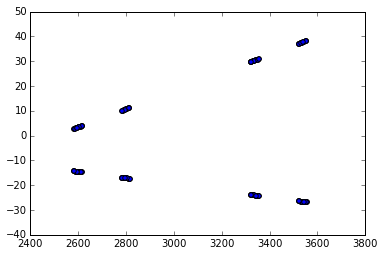

In [962]:
plt.scatter(event.Z.values, event.X.values)
plt.show()

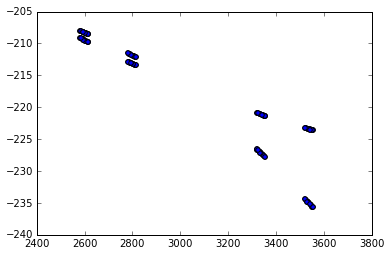

In [963]:
plt.scatter(event.Z.values, event.Y.values)
plt.show()

In [935]:
%%time
rt = DeformableTemplates(n_tracks=2, n_iters=1, lambda_=0.1, T=0.1, min_state_value=0.5)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_
#tracks_params = stm.tracks_params_

CPU times: user 31.9 ms, sys: 4.47 ms, total: 36.3 ms
Wall time: 33 ms


In [936]:
# plt.hist(rt.all_energies, bins=100)
# plt.show()

In [937]:
#plt.plot(rt.energies_)

In [938]:
#tracks_params = rt.all_params[rt.all_energies == rt.all_energies.min()][0]

In [939]:
tracks_params

array([[ -2.47773872e-03,  -5.33859478e+01],
       [ -8.90837269e-03,  -3.59269499e+01]])

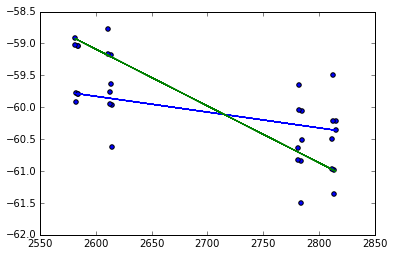

In [940]:
plt.scatter(x, y)
n = 1
plt.plot(x, tracks_params[0][0] * x + tracks_params[0][1])
plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [941]:
numpy.round(rt.states_, 2)

array([[ 0.  ,  0.  ],
       [ 0.01,  0.72],
       [ 0.73,  0.  ],
       [ 0.62,  0.01],
       [ 0.17,  0.6 ],
       [ 0.03,  0.68],
       [ 0.  ,  0.71],
       [ 0.63,  0.08],
       [ 0.05,  0.  ],
       [ 0.69,  0.03],
       [ 0.69,  0.  ],
       [ 0.01,  0.72],
       [ 0.  ,  0.73],
       [ 0.71,  0.  ],
       [ 0.  ,  0.71],
       [ 0.  ,  0.32],
       [ 0.69,  0.  ],
       [ 0.  ,  0.41],
       [ 0.69,  0.  ],
       [ 0.37,  0.4 ],
       [ 0.04,  0.67],
       [ 0.  ,  0.01],
       [ 0.73,  0.  ],
       [ 0.02,  0.72],
       [ 0.61,  0.01],
       [ 0.71,  0.  ],
       [ 0.72,  0.01],
       [ 0.53,  0.14],
       [ 0.  ,  0.71],
       [ 0.01,  0.  ],
       [ 0.73,  0.  ],
       [ 0.01,  0.73]])

#### from metrics import HitsMatchingEfficiency

In [890]:
from metrics import HitsMatchingEfficiency
hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [891]:
tracks_params

array([[ -6.68693009e-03,  -4.21340444e+01],
       [ -5.64826701e-03,  -4.43923756e+01]])

In [892]:
labels

array([-1.,  0., -1.,  1.,  0., -1.,  0.,  0.,  1.,  0.,  1., -1.,  1.,
       -1.,  0.,  1.])

In [893]:
event12.Label.values

array([ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.])

### Tracks Reconstruction

In [905]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = DeformableTemplates(n_tracks=2, n_iters=1, lambda_=0.1, T=0.1, min_state_value=0.5)
    stm_stereo = DeformableTemplates(n_tracks=1, n_iters=1, lambda_=0.1, T=10, min_state_value=0.5)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids[::10])
    tracks = merge_dicts(results)

CPU times: user 61.6 ms, sys: 73.4 ms, total: 135 ms
Wall time: 5.85 s


In [906]:
#tracks_reconstruction(2)

In [907]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_y_ == 1)*1, 
                                                     (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_y_ == 1)*1, 
                                                     (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()


CPU times: user 2.01 s, sys: 101 ms, total: 2.11 s
Wall time: 2.13 s


In [908]:
combinations_quality.head(10)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,4927,1,0,0,2
1,1793,1,0,0,2
2,2,1,0,0,2
3,2305,1,0,0,2
4,1546,1,0,0,2
5,1111,1,0,0,2
6,3329,1,0,0,2
7,3812,1,0,0,2
8,654,1,0,0,2
9,3899,1,0,0,2


In [909]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

10

In [910]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4927,1,1,0,0
1,1793,1,1,0,0
2,2,1,1,0,0
3,2305,1,1,0,0
4,1546,1,1,0,0
5,1111,1,1,0,0
6,3329,1,1,0,0
7,3812,1,1,0,0
8,654,1,1,0,0
9,3899,1,1,0,0


In [911]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4927,1,1,0,0
1,1793,1,1,0,0
2,2,1,1,0,0
3,2305,1,1,0,0
4,1546,1,1,0,0
5,1111,1,1,0,0
6,3329,1,1,0,0
7,3812,1,1,0,0
8,654,1,1,0,0
9,3899,1,1,0,0


In [912]:
tracks_metrics_before_y[tracks_metrics_before_y.RecoEff != 1]

,EventID,AvgEff,RecoEff,GhostRate,CloneRate


# Quality

# Stations 1&2

### Y-views

In [913]:
tracks_metrics_before_y.mean(axis=0)

EventID      2523.208955
AvgEff          0.988701
RecoEff         1.000000
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Stereo-views

In [914]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2523.208955
AvgEff          0.987313
RecoEff         0.970149
GhostRate       0.014925
CloneRate       0.014925
dtype: float64

### Stations 1&2

In [915]:
tracks_metrics_before_all.mean(axis=0)

EventID      2523.208955
AvgEff          0.985130
RecoEff         1.000000
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Track efficiency

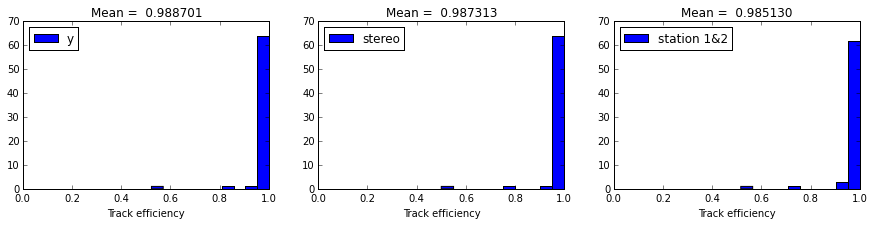

In [916]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

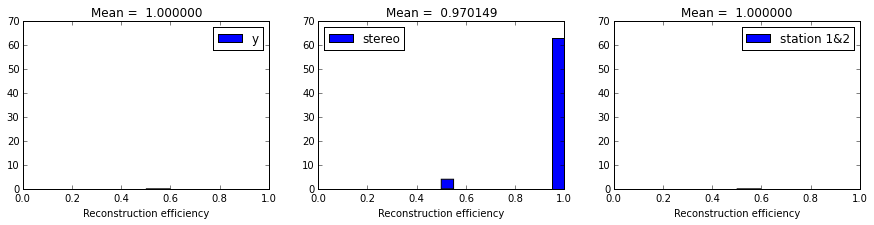

In [917]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [918]:
tracks_metrics_after_y.mean(axis=0)

EventID      2523.208955
AvgEff          0.998109
RecoEff         1.000000
GhostRate       0.000000
CloneRate       0.014925
dtype: float64

### Stereo-views

In [919]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2523.208955
AvgEff          1.000000
RecoEff         0.992537
GhostRate       0.000000
CloneRate       0.007463
dtype: float64

### Station 3&4

In [920]:
tracks_metrics_after_all.mean(axis=0)

EventID      2523.208955
AvgEff          0.998690
RecoEff         0.992537
GhostRate       0.000000
CloneRate       0.007463
dtype: float64

### Tracks efficiency

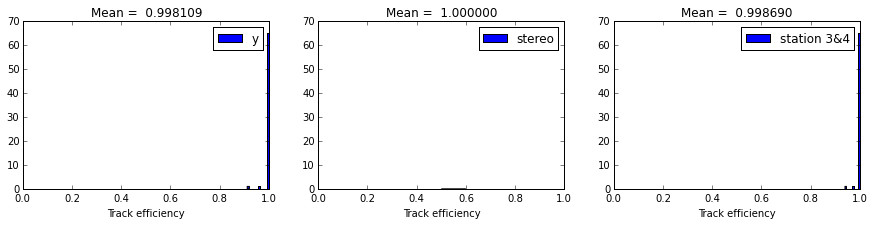

In [921]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

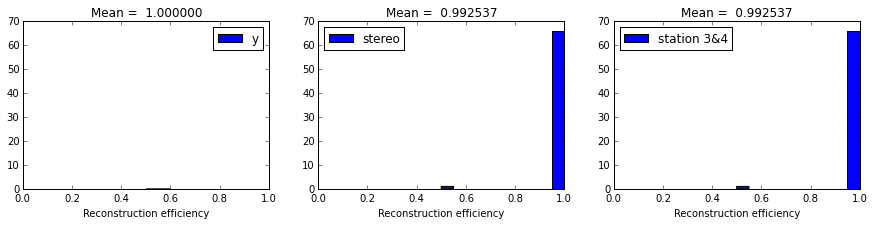

In [922]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [923]:
combinations_quality.mean(axis=0)

EventID      2523.208955
RecoEff         0.977612
GhostRate       0.007463
CloneRate       0.007463
NCombined       1.970149
dtype: float64

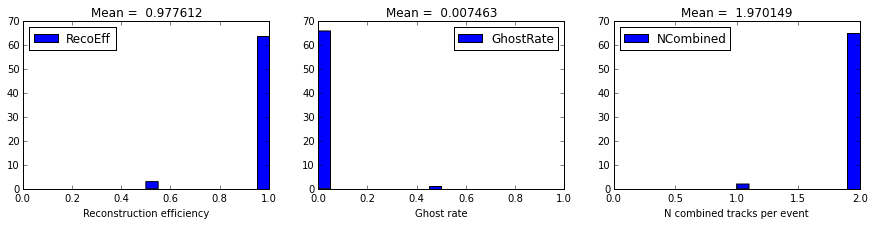

In [924]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

95.5223880597


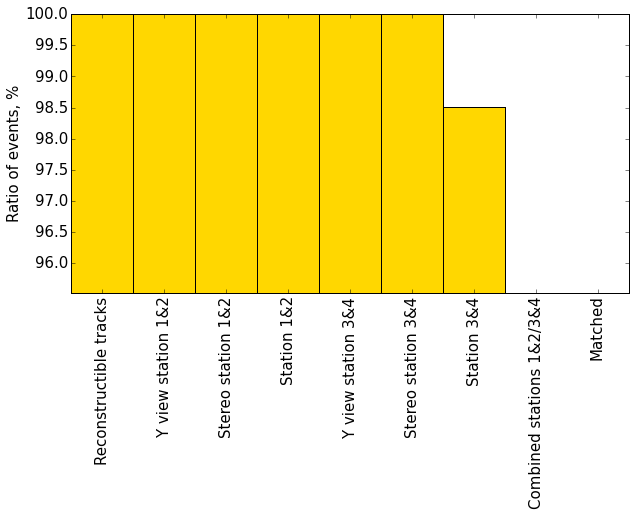

In [925]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [926]:
bar_values

array([ 100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,   98.50746269,   95.52238806,
         95.52238806])

# Momentum

In [927]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

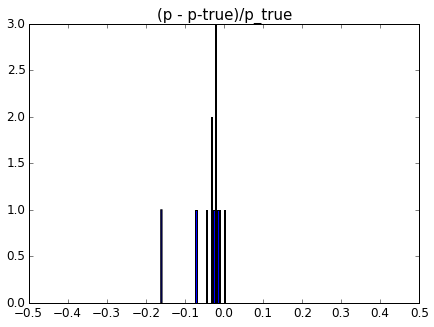

In [928]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [929]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

0

# Did not recognized tracks

In [930]:
pass_stages['EventID'] = tracks.keys()
pass_stages[pass_stages.Matching.values == 0]

,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching,EventID
14,1,1,1,1,1,1,1,0,0,793
30,1,1,1,1,1,1,0,0,0,1722
43,1,1,1,1,1,1,1,0,0,2263


In [931]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

793


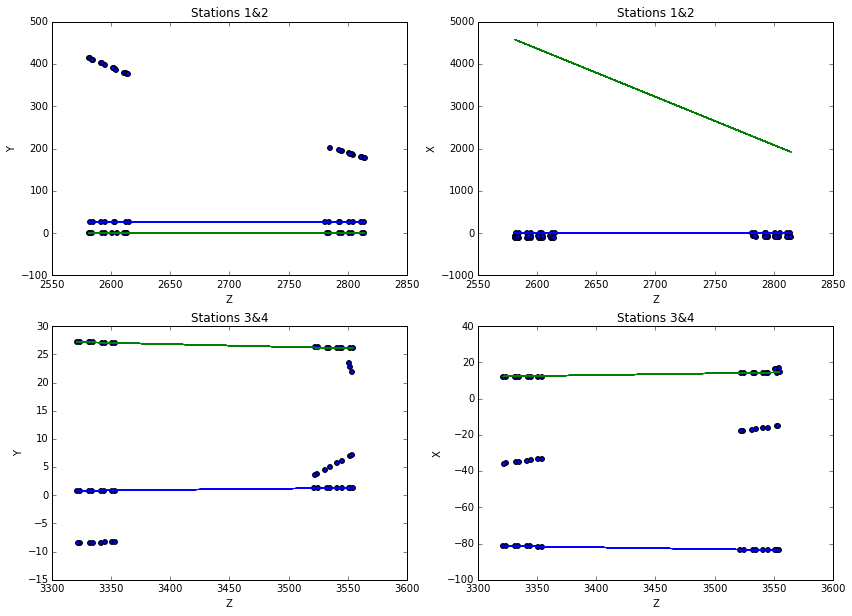

1722


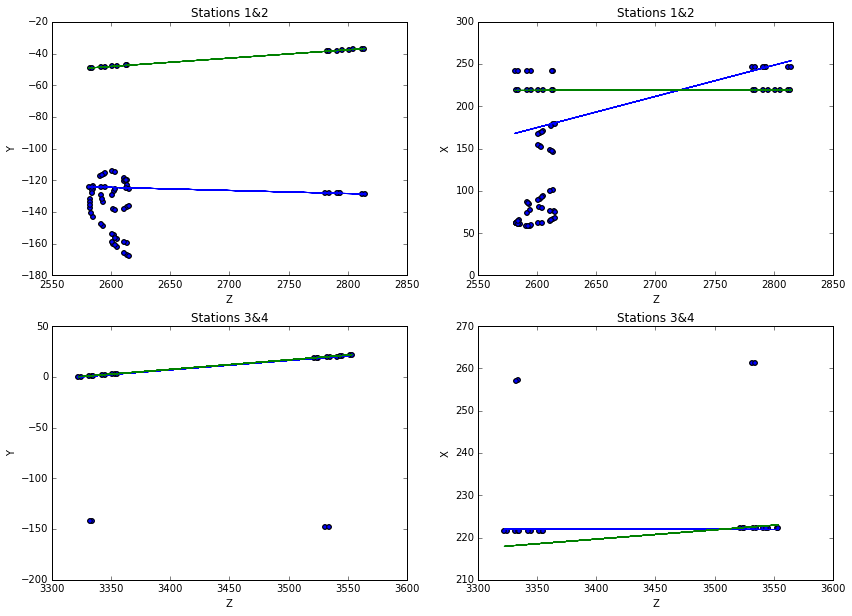

2263


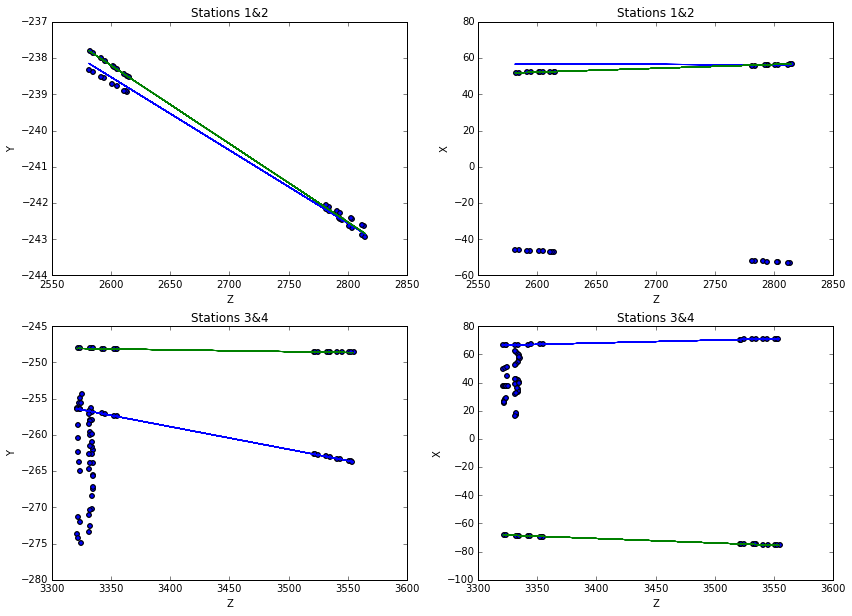

In [932]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)